In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import minimize, fmin_tnc # optimize the gradient descent
from sklearn.preprocessing import PolynomialFeatures # map polynomial features
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Used to plot the cost function vs # of iterations
global cf_vs_iter, iter_count
iter_count = 0
cf_vs_iter = DataFrame(columns=['J_theta', '# of iterations'])

### Learning Algorithm

Learning algorithm to compute the classifier for a binary classification problem. Takes in the training set, hypothesis builder, and the highest polynomial degree of the decision boundary function

In [4]:
def learning_algorithm(training_set, hypothesis, polynomial_degree, regularized_parameter):

    # Clear the list for new cost funtion plot
    global cf_vs_iter, iter_count
    cf_vs_iter = DataFrame(columns=['J_theta', '# of iterations'])
    iter_count = 0
    
    X = DataFrame.as_matrix(training_set[training_set.columns[:-1]]) # The numpy array excluding output y column
    Y = np.transpose(np.matrix(training_set[training_set.columns[-1]])) # The output vector
    
    # map the polynomial features incase the hypothesis function is non-linear
    # Generate a new feature matrix consisting of all polynomial combinations of the features with degree 
    # less than or equal to the specified degree. For example, if an input sample is two dimensional and of 
    # the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
    # Note that this function inserts a column with 'ones' in the design matrix for the intercept.
    poly = PolynomialFeatures(polynomial_degree)
    XX = poly.fit_transform(X)
    
    features_count = XX.shape[1] # Number of features
    training_count = len(training_set) # Number of training examples
    thetas = np.zeros(features_count) # Thetas vector
    
    # minize the cost function using scipy optimization
    result = minimize(fun = cost_function, 
                      x0 = thetas, 
                      args = (XX, Y, regularized_parameter), 
                      method = 'L-BFGS-B', 
                      jac=gradient)
    #result = fmin_tnc(func=cost_function, x0=thetas, fprime=gradient, args=(XX, Y, regular_param))
    #result = minimize(cost_function, thetas, args=(XX,Y, regular_param), method=None, jac=gradient, options={'maxiter':400})
    thetas = result.x
    print(result)
    
    def h(inputs):
        return hypothesis(thetas, inputs)
    
    return [h, thetas, X, XX, Y]

### Gradient of Cost Function

In [5]:
def gradient(thetas, X, Y, regular_param):

    training_count = len(X)
    
    # Compute the sigmoid function
    htheta = sigmoid(X*np.matrix(thetas).transpose())
    
    # Compute the regularized thetas vector but ignore the bias unit
    regularized_thetas = thetas*regular_param
    regularized_thetas[0] = 0
    regularized_thetas = np.matrix(regularized_thetas).transpose()
    
    gradient = ((1/training_count)*(np.transpose(X)*(htheta-Y) + regularized_thetas)).flatten()
    gradient = np.array(gradient.tolist()[0])

    return gradient

### The Cost Function

In [6]:
def cost_function(thetas, X, Y, regular_param):

    training_count = len(X)
    htheta = sigmoid(X*np.matrix(thetas).transpose())
    comp1 = np.sum(np.multiply(np.log(htheta),-Y)-np.multiply((1-Y),np.log(1-htheta))) / training_count # Compute the cost
    comp2 = (regular_param/(2*training_count))*np.sum(np.square(thetas))
    
    # For plotting cost vs iteration
    global cf_vs_iter, iter_count
    cf_vs_iter = cf_vs_iter.append(DataFrame([[comp1+comp2,iter_count]], columns=['J_theta', '# of iterations']), ignore_index=True)
    iter_count += 1

    return comp1+comp2

### The Sigmoid Function 

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

### Classifier Generator

In [8]:
def hypothesis_builder(polynomial_degree):
    def hypothesis(thetas, features):
        
        # Process the input features vector with correct polynomial degree
        poly = PolynomialFeatures(polynomial_degree)
        features = np.array([features])
        features = poly.fit_transform(features)
        
        # Turn thetas array into a vector
        thetas = np.matrix(thetas).transpose()
        
        return sigmoid(np.sum(features*thetas))
    return hypothesis

### Function for Plotting Data

In [9]:
# Plot data function got from online resource at
# http://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%202%20-%20Logistic%20Regression.ipynb
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

### Load Data

In [10]:
# Load training set
training_data = DataFrame.from_csv('ex2data2.txt', index_col=None)
print(training_data.loc[0:10])

         x_1       x_2  y
0   0.051267  0.699560  1
1  -0.092742  0.684940  1
2  -0.213710  0.692250  1
3  -0.375000  0.502190  1
4  -0.513250  0.465640  1
5  -0.524770  0.209800  1
6  -0.398040  0.034357  1
7  -0.305880 -0.192250  1
8   0.016705 -0.404240  1
9   0.131910 -0.513890  1
10  0.385370 -0.565060  1


C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


### Plot Classification Data

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


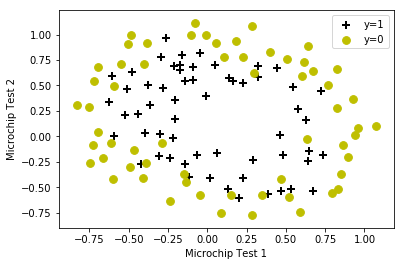

In [11]:
# Plot classification data
plotData(training_data.as_matrix(), 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')

### Polynomial Degree & Regularized Parameter

In [12]:
k = 6 # Polynomial degree, non-linear decision boundary of degree 6
regular_param = 0 # regularized parameter

### Create Classifier Builder with Polynomial Degree k

In [13]:
# Create the classifier builder
h_builder = hypothesis_builder(k)

### Start Learning The Classifier

In [14]:
# Run gradient descent algorithm
# result[0] = classifier
# result[1] = thetas
# result[2] = X
# result[3] = XX
# result[4] = Y
result = learning_algorithm(training_data, h_builder, k, regular_param)

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


      fun: 0.21945970681559254
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.08006545e-06, -1.31073233e-06,  3.96342173e-06,  6.36535574e-06,
        6.78167884e-06, -7.29765304e-07, -4.87774581e-06, -3.23136091e-06,
       -9.85205429e-07,  1.47640665e-06,  3.99004893e-06, -4.27376720e-06,
        8.35321581e-07,  4.66185406e-06,  5.15332921e-07, -6.18167084e-06,
        2.23529448e-06, -1.06987409e-06, -1.20557375e-06,  2.11259869e-06,
        2.15102505e-06,  3.29472278e-06, -2.36044177e-06,  1.90605688e-06,
        1.35385929e-06, -3.37753612e-06,  1.79367445e-06,  4.47993705e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5151
      nit: 3870
   status: 0
  success: True
        x: array([   38.70250192,    56.01270994,   102.80450465,  -371.43069966,
        -176.26134368,  -197.59683219,  -364.30499693,  -867.35838777,
        -750.72261545,  -544.60181058,  1182.30641612,  1280.35420479,
        1939.22678829,   9

### Plot Cost Function over Each Iteration

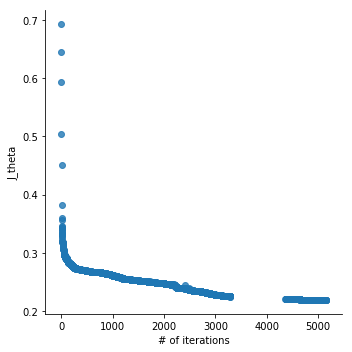

In [15]:
# Plot cost function vs # iterations
plot = sns.lmplot(x="# of iterations", y="J_theta",data=cf_vs_iter, fit_reg=False)
axes = plot.axes

### Test Classifier

In [16]:
print('The probability of y=1 is', result[0]([0.2,0.6]))

The probability of y=1 is 0.6638893515008427


### Display Accuracy for Learning The Classifier with λ=0

In [17]:
def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [18]:
# Display the training accuracy
p = predict(result[1], result[3])
print('Train accuracy is {}%'.format(100*sum(p == np.array(result[4].flatten().tolist()[0]).ravel())/p.size))

Train accuracy is 88.98305084745763%


### Start Learning Algorithm & Display Decision Boundary for Different Regularized Parameter

Start the learning algorithm on input training data with regularized parameter of 0, 1, and 100. Also display the decision boundary with respect to different λ to see how λ affects the performance of the output classifier

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


      fun: 0.21945970681559254
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.08006545e-06, -1.31073233e-06,  3.96342173e-06,  6.36535574e-06,
        6.78167884e-06, -7.29765304e-07, -4.87774581e-06, -3.23136091e-06,
       -9.85205429e-07,  1.47640665e-06,  3.99004893e-06, -4.27376720e-06,
        8.35321581e-07,  4.66185406e-06,  5.15332921e-07, -6.18167084e-06,
        2.23529448e-06, -1.06987409e-06, -1.20557375e-06,  2.11259869e-06,
        2.15102505e-06,  3.29472278e-06, -2.36044177e-06,  1.90605688e-06,
        1.35385929e-06, -3.37753612e-06,  1.79367445e-06,  4.47993705e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5151
      nit: 3870
   status: 0
  success: True
        x: array([   38.70250192,    56.01270994,   102.80450465,  -371.43069966,
        -176.26134368,  -197.59683219,  -364.30499693,  -867.35838777,
        -750.72261545,  -544.60181058,  1182.30641612,  1280.35420479,
        1939.22678829,   9

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation fo

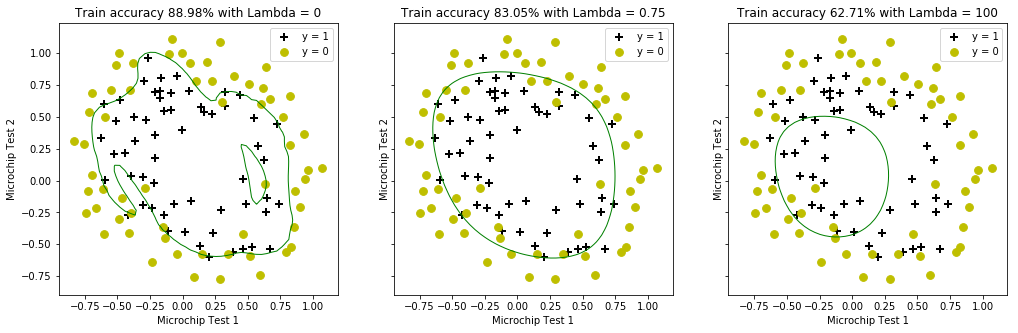

In [24]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Display the decision boundary
# Source code: # http://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%202%20-%20Logistic%20Regression.ipynb
for i, C in enumerate([0, 0.75, 100]):
    
    # Read input data
    data = DataFrame.from_csv('ex2data2.txt', index_col=None)
    
    # Set degree of polynomials
    degree = 6
    
    # Create a classifier builder of degree 6
    classifier_builder = hypothesis_builder(degree)
    
    # Start the learning algorithm
    res = learning_algorithm(data, classifier_builder, degree, C)
    
    thetas = res[1]
    X = res[2]
    XX = res[3]
    y = res[4]
    poly = PolynomialFeatures(degree)
    
    # Accuracy
    accuracy = 100*sum(predict(thetas, XX) == np.array(y.flatten().tolist()[0]))/y.size    

    # Scatter plot of X,y
    plotData(training_data.as_matrix(), 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])

    # Plot decision boundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be rem

      fun: 0.579986954314601
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.11717586e-03,  7.24646494e-04,  3.40754224e-04,  4.29571995e-04,
        7.92634233e-04,  1.66120947e-03, -4.66649166e-05,  2.06128954e-04,
        4.07219987e-04, -1.07598887e-04, -1.11726675e-04, -4.98422137e-05,
        3.44039643e-04,  2.52237726e-04,  2.23787767e-04, -2.55406581e-04,
        4.34032166e-06,  1.06892021e-05,  1.37126036e-04,  2.32820058e-04,
       -7.07629784e-04, -3.42738501e-04, -1.25376118e-04,  1.12940162e-04,
       -4.53659311e-05,  1.35205441e-04,  1.00627739e-04, -6.36203875e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 9
   status: 0
  success: True
        x: array([ 0.8714939 ,  0.34434346,  0.76356534, -1.36174875, -0.4840274 ,
       -0.82671417,  0.00675147, -0.21440356, -0.21798925, -0.16981122,
       -1.01360842, -0.05026128, -0.38486469, -0.13794707, -0.81411245,
       -0.21774883, -0.13501738

C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\phung\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


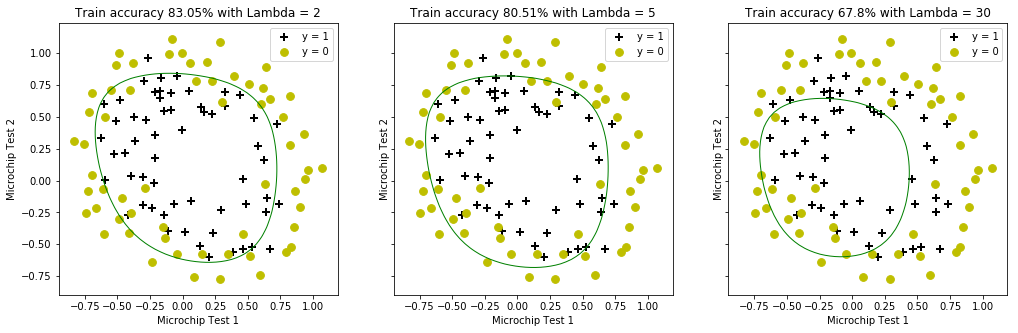

In [25]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Display the decision boundary
# Source code: # http://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%202%20-%20Logistic%20Regression.ipynb
for i, C in enumerate([2, 5, 30]):
    
    # Read input data
    data = DataFrame.from_csv('ex2data2.txt', index_col=None)
    
    # Set degree of polynomials
    degree = 6
    
    # Create a classifier builder of degree 6
    classifier_builder = hypothesis_builder(degree)
    
    # Start the learning algorithm
    res = learning_algorithm(data, classifier_builder, degree, C)
    
    thetas = res[1]
    X = res[2]
    XX = res[3]
    y = res[4]
    poly = PolynomialFeatures(degree)
    
    # Accuracy
    accuracy = 100*sum(predict(thetas, XX) == np.array(y.flatten().tolist()[0]))/y.size    

    # Scatter plot of X,y
    plotData(training_data.as_matrix(), 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])

    # Plot decision boundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))